In [193]:
from pathlib import Path
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import seaborn as sns
import contextily as ctx
import copy
from scipy.stats import norm
from plot_functions import plot_vakindeling, plot_assessment_betas, plot_assessment_probabilities, plot_pf_length_cost
from load_output import read_assessment_betas, get_traject_prob_development
sns.set_style('whitegrid')

In [2]:
shape_dir = Path(r'c:\Users\klerk_wj\OneDrive - Stichting Deltares\00_Projecten\11_VR_Prioritering WSRL\Gegevens 38-1')
results_dir = Path(r'c:\Users\klerk_wj\OneDrive - Stichting Deltares\00_Projecten\11_VR_Prioritering WSRL\Berekeningen 38-1\Berekening_20230307')
run = 'sterker_VZG2'
shapefile = gpd.read_file(shape_dir.joinpath('00_data_workflow','intermediate','Vakindeling_Veiligheidsrendement.shp'))
shapefile.crs='EPSG:28992'
shapefile = shapefile.to_crs(epsg=3857)
# shapefile.to_crs(epsg=4326)
for count, section in shapefile.iterrows():
    if len(section.NUMMER) ==1:
        #pad 0:
        shapefile.loc[count,'NUMMER']= '{:02d}'.format(np.int32(section.NUMMER))

## Plot vakindeling

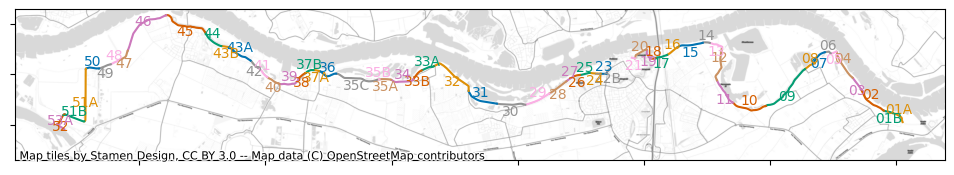

In [4]:
plot_vakindeling(shapefile, results_dir.joinpath(run, 'extra_resultaten', 'vakindeling.png'))

## Plot beoordeling

In [3]:
InitialAssessmentBetas, InitialAssessmentProbabilities = read_assessment_betas(results_dir.joinpath(run, 'InitialAssessment_Betas.csv'))


In [4]:
plot_assessment_betas(shapefile, InitialAssessmentBetas, results_dir.joinpath(run,'extra_resultaten'), year = 2025)

plot_assessment_probabilities(shapefile, InitialAssessmentProbabilities, results_dir.joinpath(run,'extra_resultaten'), year = 2025)

plot_assessment_probabilities(shapefile, InitialAssessmentProbabilities, results_dir.joinpath(run,'extra_resultaten'), year = 2075)



## Maatregelen

### Versterkte lengte

In [4]:
initial_beta = InitialAssessmentBetas.loc[InitialAssessmentBetas.mechanism!='Section'].set_index(['name','mechanism']).drop(columns=['Length'])
section_lengths = InitialAssessmentBetas.loc[InitialAssessmentBetas.mechanism=='Section'].set_index('name')['Length']
vr = {}

#optimale maatregelen
vr['optimal_measures'] = pd.read_csv(results_dir.joinpath(run,'TakenMeasures_Optimal_Veiligheidsrendement.csv'),index_col=2)
#maatregelvolgorde, optie 1: eerste investering als eerste
vr['taken_measures'] = pd.read_csv(results_dir.joinpath(run,'TakenMeasures_Veiligheidsrendement.csv'),index_col=0)
vr['section_order'], vr['traject_probs'] = get_traject_prob_development(vr['optimal_measures'],
                                                                  vr['taken_measures'],
                                                                  initial_beta,
                                                                  option_dir = results_dir.joinpath(run))

dsn = {}
#optimale maatregelen referentie
dsn['optimal_measures'] = pd.read_csv(results_dir.joinpath(run,'FinalMeasures_Doorsnede-eisen.csv'),index_col=2)
#maatregelvolgorde, optie 1: eerste investering als eerste
dsn['taken_measures'] = pd.read_csv(results_dir.joinpath(run,'TakenMeasures_Doorsnede-eisen.csv'),index_col=0)
dsn['section_order'], dsn['traject_probs'] = get_traject_prob_development(dsn['optimal_measures'],
                                                                    dsn['taken_measures'] ,
                                                                    initial_beta, 
                                                                    option_dir = results_dir.joinpath(run),
                                                                    calc_type='Doorsnede-eisen')





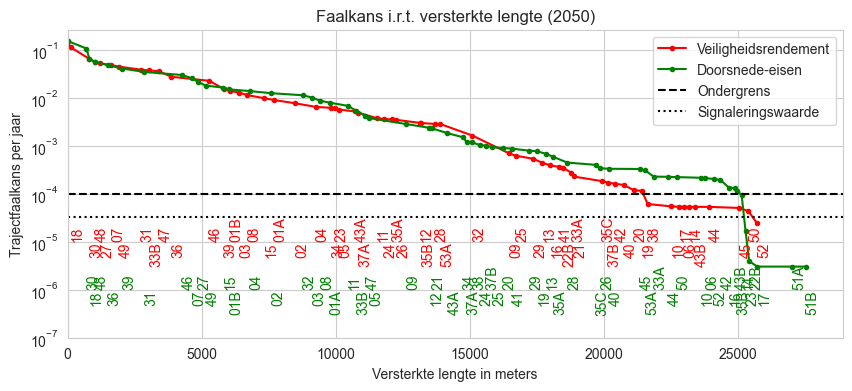

In [5]:
plot_pf_length_cost(vr, dsn,
                            initial_beta, shapefile, 
                            results_dir.joinpath(run,'extra_resultaten'),
                            section_lengths,
                            mode= 'Length',
                            year = 2050)



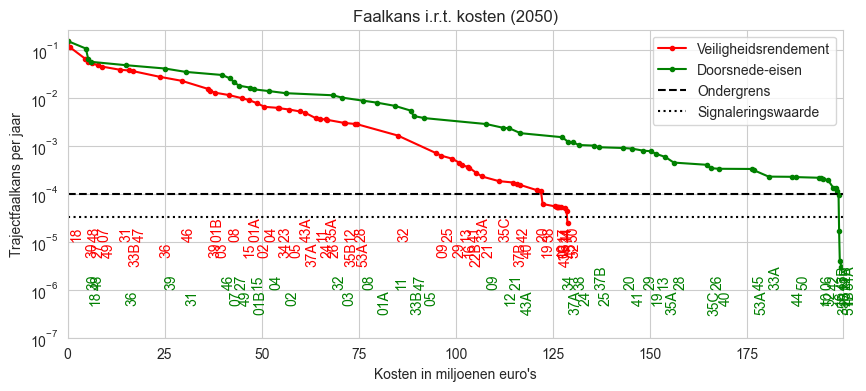

In [6]:
plot_pf_length_cost(vr, dsn,
                            initial_beta, shapefile, 
                            results_dir.joinpath(run,'extra_resultaten'),
                            section_lengths,
                            mode= 'Cost',
                            year = 2050)

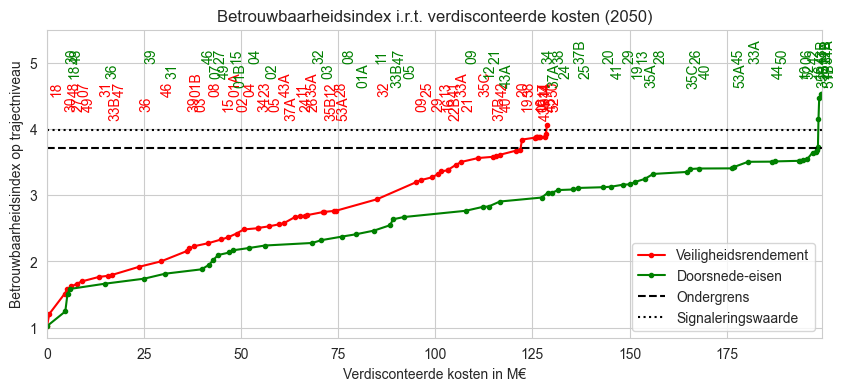

In [98]:
year_ind = 3
year = np.int_(InitialAssessmentBetas.drop(columns=['name','mechanism','Length']).columns.values[year_ind])+2025
fig, ax = plt.subplots(figsize=(10,4))
x_vr = pd.concat([pd.Series([0]), get_cum_costs(section_order_vr,optimal_measures_vr)])
x_dsn = pd.concat([pd.Series([0]), get_cum_costs(section_order_dsn,optimal_measures_dsn)])
ax.plot(x_vr,-norm.ppf(traject_probs_vr[:,year_ind]),label= 'Veiligheidsrendement',color='red',marker='.')
ax.plot(x_dsn,-norm.ppf(traject_probs_dsn[:,year_ind]),label= 'Doorsnede-eisen',color='green',marker='.')
ax.hlines(-norm.ppf(1./10000),0,shapefile.MEAS_END.max(),label='Ondergrens',color='k',linestyle='--')

ax.hlines(-norm.ppf(1./30000),0,shapefile.MEAS_END.max(),label='Signaleringswaarde',color='k',linestyle=':')
#text labels vr:
for count, section in enumerate(section_order_vr,1):
    if (count % 2) == 0:
        ax.text(x_vr.iloc[count],4.5,section.strip('DV'),rotation=90,verticalalignment='top',color='red')
    else:
        ax.text(x_vr.iloc[count],4.5,section.strip('DV'),rotation=90,verticalalignment='bottom',color='red')
        
#text labels dsn:
for count, section in enumerate(section_order_dsn,1):
    if (count % 2) == 0:
        ax.text(x_dsn.iloc[count],5,section.strip('DV'),rotation=90,verticalalignment='top',color='green')
    else:
        ax.text(x_dsn.iloc[count],5,section.strip('DV'),rotation=90,verticalalignment='bottom',color='green')
# ax.set_yscale('log')
x_max_right = np.max([get_cum_costs(section_order_vr,optimal_measures_vr).max(),get_cum_costs(section_order_dsn,optimal_measures_dsn).max()])
ax.set_xlim(left=0,right=x_max_right)
ax.set_ylim(top=5.5)
ax.set_title('Betrouwbaarheidsindex i.r.t. verdisconteerde kosten ({})'.format(year))
ax.set_ylabel('Betrouwbaarheidsindex op trajectniveau')
ax.set_xlabel('Verdisconteerde kosten in M€')
ax.legend(loc='lower right')
plt.savefig(results_dir.joinpath(run,'extra_resultaten','kosten vs beta in {}.png'.format(year)),dpi=300,bbox_inches='tight')


Vergelijking optimalisatiepad, versus veiligheidsrendement opgebost per vak.

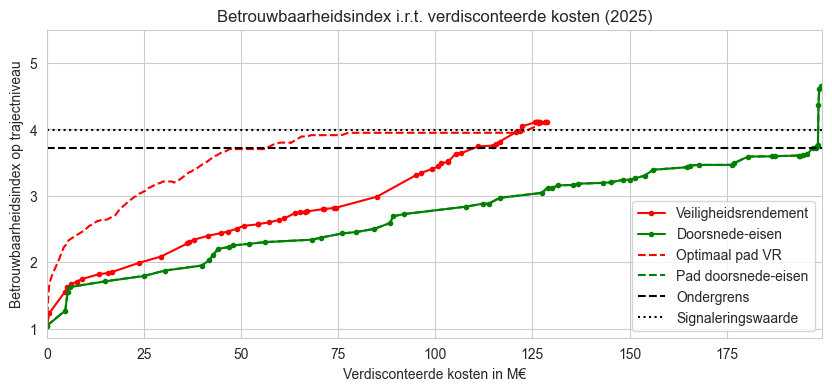

In [100]:
year_ind = 0 #2025
year = np.int_(InitialAssessmentBetas.drop(columns=['name','mechanism','Length']).columns.values[year_ind])+2025
fig, ax = plt.subplots(figsize=(10,4))
x_vr = pd.concat([pd.Series([0]), get_cum_costs(section_order_vr,optimal_measures_vr)])
x_dsn = pd.concat([pd.Series([0]), get_cum_costs(section_order_dsn,optimal_measures_dsn)])
ax.plot(x_vr,-norm.ppf(traject_probs_vr[:,year_ind]),label= 'Veiligheidsrendement',color='red',marker='.')
ax.plot(x_dsn,-norm.ppf(traject_probs_dsn[:,year_ind]),label= 'Doorsnede-eisen',color='green',marker='.')

optimal_path = pd.read_csv(results_dir.joinpath(run, 'Beta vs LCC_Optimized investment_t2025.csv'),index_col=0)
ax.plot(optimal_path.Cost,optimal_path.beta,color='red',linestyle='--',label='Optimaal pad VR')

dsn_path = pd.read_csv(results_dir.joinpath(run, 'Beta vs LCC_Target reliability based investment_t2025.csv'),index_col=0)
ax.plot(dsn_path.Cost,dsn_path.beta,color='green',linestyle='--',label='Pad doorsnede-eisen')

ax.hlines(-norm.ppf(1./10000),0,shapefile.MEAS_END.max(),label='Ondergrens',color='k',linestyle='--')
ax.hlines(-norm.ppf(1./30000),0,shapefile.MEAS_END.max(),label='Signaleringswaarde',color='k',linestyle=':')


ax.set_xlim(left=0,right=get_cum_costs(section_order_dsn,optimal_measures_dsn).max())
ax.set_ylim(top=5.5)
ax.set_title('Betrouwbaarheidsindex i.r.t. verdisconteerde kosten ({})'.format(year))
ax.set_ylabel('Betrouwbaarheidsindex op trajectniveau')
ax.set_xlabel('Verdisconteerde kosten in M€')
ax.legend(loc='lower right')
plt.savefig(results_dir.joinpath(run,'extra_resultaten','vergelijking optimalisatiepad {}.png'.format(year)),dpi=300,bbox_inches='tight')


## Maatregelen per vak

In [12]:
#dijkvak 46
section='09'
vr_measures = pd.read_csv(results_dir.joinpath(run,'DV{}_Options_Veiligheidsrendement.csv'.format(section)))
# section =69
# safepath = Path(r'c:\Users\klerk_wj\OneDrive - Stichting Deltares\00_Projecten\04_SAFE\data_repos\cases\Testcase_SAFE_v12_16-3\Case_maatregelen_alle_vakken\results\DV{}_Options_Veiligheidsrendement.csv'.format(section))
# vr_measures = pd.read_csv(safepath)

vr_measures = vr_measures.loc[1:]
LCCs = []
r = 1.015
for count, row in vr_measures.iterrows():
    # if count > 0:
    try:
        LCCs.append(np.float32(row.cost)/((r**np.int32(row.year))))
    except:
        c = row.cost.strip('[').strip(']').split(',')
        t = row.year.strip('[').strip(']').split(',')
        LCC0 = 0
        for i,c0 in enumerate(c):
            LCC0+= np.float32(c0)/(r**np.int32(t[i]))
        LCCs.append(LCC0)
        # raise Exception('fout')
    # else:
    #     LCCs.append(0.)
vr_measures['LCC'] = LCCs

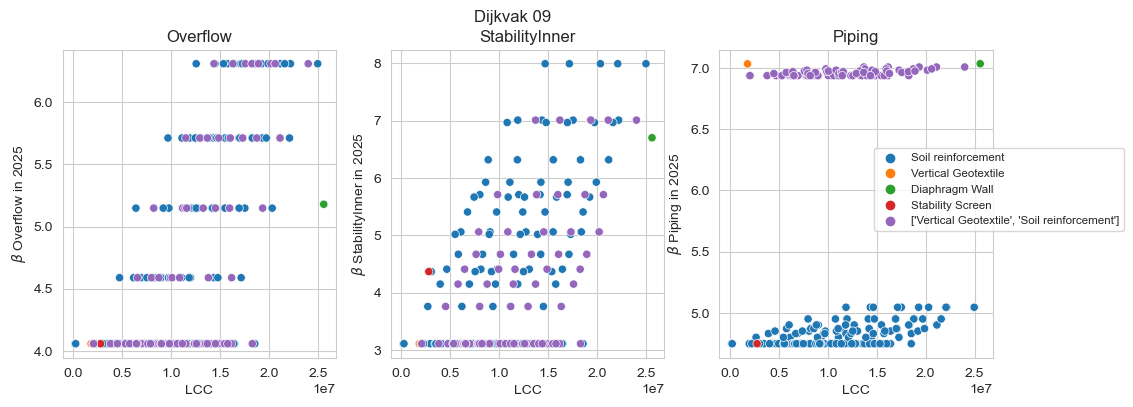

In [13]:
fig, axes = plt.subplots(figsize=(12,4),ncols=3)
for i, mech in enumerate(mechanisms):
    if i!=2:
        sns.scatterplot(ax=axes[i],data=vr_measures,x='LCC',y= '{}.1'.format(mech),hue= 'type',legend=False)
    else:
        sns.scatterplot(ax=axes[i],data=vr_measures,x='LCC',y= '{}.1'.format(mech),hue= 'type')
        axes[i].legend(bbox_to_anchor=(1.5,.7),fontsize='small')
    axes[i].set_title(mech)
    axes[i].set_ylabel(r'$\beta$ {} in 2025'.format(mech))
fig.suptitle('Dijkvak {}'.format(section))
plt.savefig(results_dir.joinpath(run,'extra_resultaten','maatregelen dijkvak {}.png'.format(section)),dpi=300,bbox_inches='tight')


## Resultaten

C:\Users\klerk_wj\Miniconda3\envs\vr_preprocessing\lib\site-packages\geopandas\plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


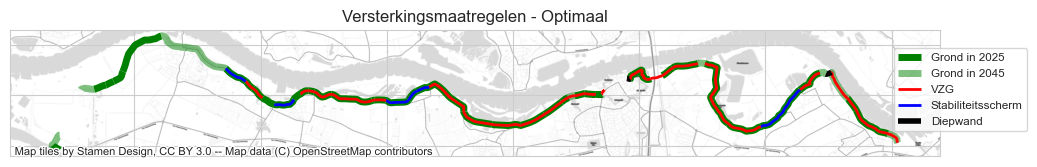

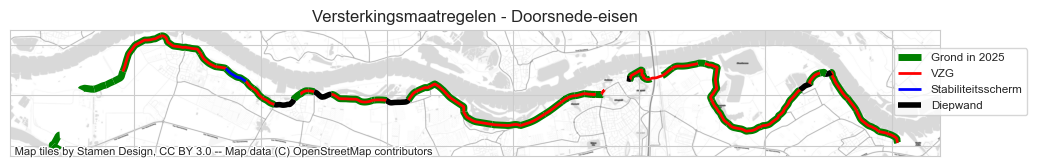

In [40]:
def add_characteristic_columns(result_df):
    #cleaning data
    for count, line in result_df.iterrows():
        try:
            result_df.loc[count,'Section'] = line['Section'].strip('DV')
        except:
            pass
    result_df['In 2045'] = result_df['ID'].str.contains("1", case=False)
    result_df['Stabiliteitsscherm'] = result_df['ID'].str.contains("4|7", case=False)
    result_df['VZG'] = result_df['ID'].str.contains("5", case=False)
    result_df['Diepwand'] = result_df['ID'].str.contains("6", case=False)
    return result_df

# def map_of_measures(data,include_crest = True, data_type='Optimaal'):
#     sns.set_style('whitegrid')
#     fig,ax = plt.subplots(figsize=(12,5))
#     for bermwidth in np.unique(data.dberm):
#         if (bermwidth >0) and (bermwidth != np.max(np.unique(data.dberm))):
#             data.loc[data.dberm==bermwidth].plot(ax=ax,color='green',linewidth=bermwidth/2.5)#,linestyle='dashed')

#             # data.loc[data.dberm==bermwidth].loc[data['In 2045']].plot(ax=ax,color='green',linewidth=bermwidth/2.5,linestyle='dashed')
#             # data.loc[data.dberm==bermwidth].loc[~data['In 2045']].plot(ax=ax,color='green',linewidth=bermwidth/2.5)
#         elif bermwidth >0:

#             data.loc[data.dberm==bermwidth].plot(ax=ax,color='green',linewidth=bermwidth/2.5,label='Bermbreedte')
#     if include_crest:
#         for crestheight in np.unique(data.dcrest):
#             if (crestheight >0) and (crestheight != np.max(np.unique(data.dcrest))):

#                 data.loc[data.dcrest==crestheight].plot(ax=ax,color='orange',linestyle=':',linewidth=crestheight*4)
#             elif crestheight >0:

#                 data.loc[data.dcrest==crestheight].plot(ax=ax,color='orange',linestyle=':',linewidth=crestheight*4,label='Kruinverhoging')
    
#     ax.set_xticklabels([])
#     ax.set_yticklabels([])
        
#     data.loc[data.VZG].plot(ax=ax,color='r',linestyle='-',linewidth=1,label='VZG')
#     data.loc[data.Stabiliteitsscherm].plot(ax=ax,color='b',linestyle='-',linewidth=1,label='Stabiliteitsscherm')
#     data.loc[data.Diepwand].plot(ax=ax,color='darkgray',linestyle='-',linewidth=3,label='Diepwand')
#     # data.loc[data['In 2045']].plot(ax=ax,color='k',linestyle=':',label='Grond in 2045')

#     ctx.add_basemap(ax,source=ctx.providers.Stamen.TonerLite)
#     ax.legend(bbox_to_anchor=(1.1,.9),fontsize='small')
#     ax.set_title('Versterkingsmaatregelen - {}'.format(data_type))
#     # plt.savefig(results_dir.joinpath(run,'extra_resultaten','versterking_{}.png'.format(data_type)),dpi=300,bbox_inches='tight')

def map_of_measures(data,include_crest = True, data_type='Optimaal'):
    #grondwerk nu
    #grondwerk in 2045
    # VZG, SS en DW
    sns.set_style('whitegrid')
    fig,ax = plt.subplots(figsize=(12,5))

    data.loc[(data.dberm.values>0) | (data.dcrest.values > 0)].loc[~data['In 2045']].plot(ax=ax,color='green',linewidth=5,label='Grond in 2025')#,linestyle='dashed')
    data.loc[(data.dberm.values>0) | (data.dcrest.values > 0)].loc[data['In 2045']].plot(ax=ax,color='green',alpha=.5,linewidth=5,label='Grond in 2045')
    
    ax.set_xticklabels([])
    ax.set_yticklabels([])
        
    data.loc[data.VZG].plot(ax=ax,color='r',linestyle='-',linewidth=2,label='VZG')
    data.loc[data.Stabiliteitsscherm].plot(ax=ax,color='b',linestyle='-',linewidth=2,label='Stabiliteitsscherm')
    data.loc[data.Diepwand].plot(ax=ax,color='k',linestyle='-',linewidth=4,label='Diepwand')

    ctx.add_basemap(ax,source=ctx.providers.Stamen.TonerLite)
    ax.legend(bbox_to_anchor=(1.1,.9),fontsize='small')
    ax.set_title('Versterkingsmaatregelen - {}'.format(data_type))
    plt.savefig(results_dir.joinpath(run,'extra_resultaten','versterking_{}.png'.format(data_type)),dpi=300,bbox_inches='tight')
                
GreedyResult = pd.read_csv(results_dir.joinpath(run,'TakenMeasures_Optimal_Veiligheidsrendement.csv'))
GreedyResult = add_characteristic_columns(GreedyResult)
GreedyResult = shapefile.merge(GreedyResult,left_on='NUMMER',right_on='Section')
map_of_measures(GreedyResult)

DsnResult = pd.read_csv(results_dir.joinpath(run,'FinalMeasures_Doorsnede-eisen.csv'))
DsnResult = add_characteristic_columns(DsnResult)
DsnResult = shapefile.merge(DsnResult,left_on='NUMMER',right_on='Section')
map_of_measures(DsnResult,data_type = 'Doorsnede-eisen')


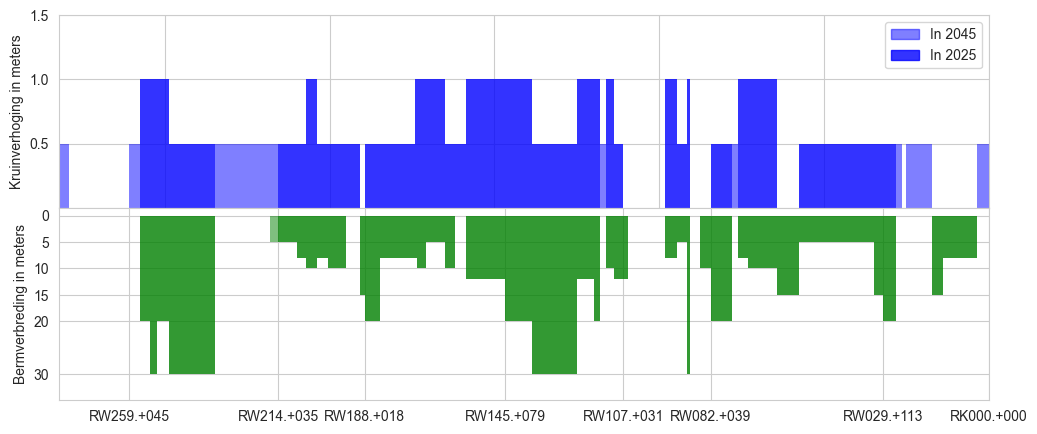

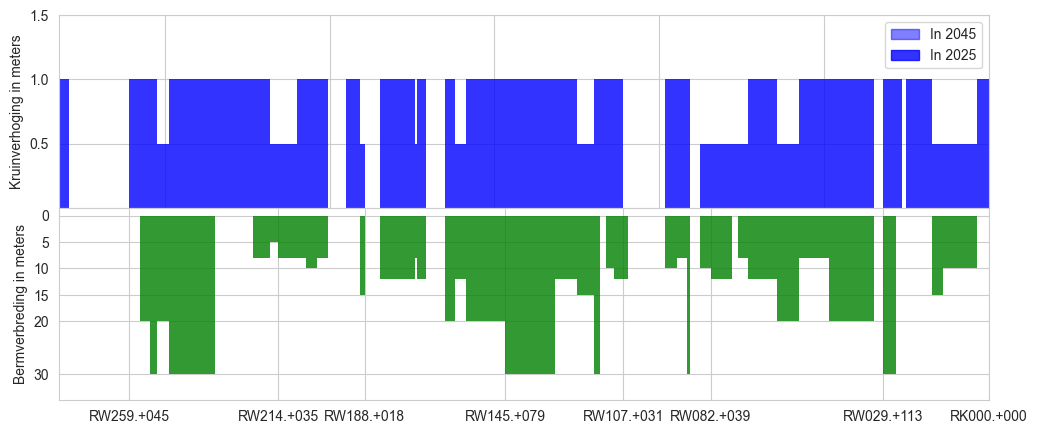

In [168]:
def select_dp(data):
    pass

def map_of_soil_dimensions(data,save_dir):
    sns.set_style('whitegrid')
    fig,ax = plt.subplots(figsize=(12,5),nrows=2)
    data = data.replace(-999.,0)
    data = data.replace(999.,0)
    data['plot_dberm'] = -data.dberm
    dp_list =[]
    m_list = []
    for count, row in data.iterrows():
        if row['In 2045']:
            alpha=0.5
        else:
            alpha=0.8
        ax[0].fill_between(x=[row.MEAS_START,row.MEAS_END],y1 = [row.dcrest]*2,y2=0,color='blue',alpha=alpha,linestyle=':',linewidth=0)
        ax[1].fill_between(x=[row.MEAS_START,row.MEAS_END],y1 = [row.plot_dberm]*2,y2=0,color='green',alpha=alpha,linestyle=':',linewidth=0)
        if (count % 8 == 0) or (count == data.shape[0]) or (count == 0):
            dp_list.append(row['VAN_DP'])
            m_list.append(row['MEAS_START'])
    ax[0].fill_between(x=[-100,-99],y1 = [0.1]*2,y2=0,color='blue',alpha=0.5,label='In 2045')
    ax[0].fill_between(x=[-100,-99],y1 = [0.1]*2,y2=0,color='blue',alpha=0.8,label='In 2025')

    # data.plot(kind='area',x='MEAS_START', y='dcrest',ax=ax[0],stacked=False)
    # data.plot(kind='line',x='MEAS_START', y='In 2045',ax=ax[0],stacked=False,linewidth=3)
    ax[0].set_ylabel('Kruinverhoging in meters')
    ax[0].set_xticks([], minor=True)
    # data.plot(kind='area',x='MEAS_START', y='plot_dberm',ax=ax[1],color='red',alpha=0.5,stacked=False)

    ax[0].set_ylim(bottom=0,top=1.5)
    ax[0].set_xlim(left=0,right=data.MEAS_START.max())
    ax[0].set_xticks([], minor=True)
    ax[0].set_xticklabels([])
    ax[0].invert_xaxis()
    ax[0].set_yticks([0.5,1.0,1.5])
    ax[0].legend()

    ax[1].set_xlim(left=0,right=data.MEAS_START.max())
    ax[1].set_xticks([], minor=True)
    ax[1].set_ylabel('Bermverbreding in meters')
    ax[1].invert_xaxis()
    bermticks = [0, -5,-10,-15,-20,-30]
    ax[1].set_ylim(bottom=-35)
    ax[1].set_yticks(bermticks,np.array(bermticks)*-1)
    ax[1].set_xticks(m_list,dp_list)
    fig.subplots_adjust(hspace=-0.)
    plt.savefig(save_dir,dpi=300,bbox_inches='tight')
    # ax2.set_ylim(bottom=-40,top=0)
    # data.plot(kind='bar',column='dberm',ax=ax)#,linewidth
map_of_soil_dimensions(GreedyResult,results_dir.joinpath(run,'extra_resultaten','dimensies_grond_vr.png'))
map_of_soil_dimensions(DsnResult,results_dir.joinpath(run,'extra_resultaten','dimensies_grond_dsn.png'))

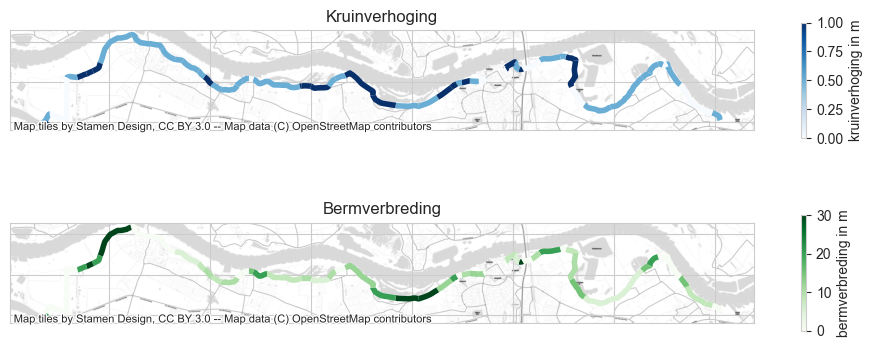

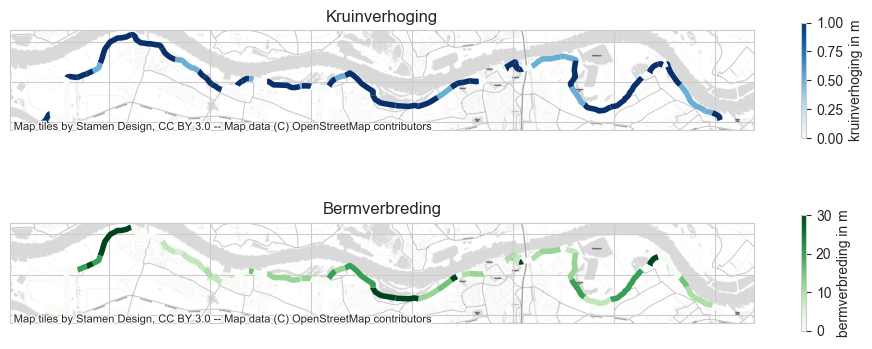

In [191]:
def plot_soil_dim_map(data, save_dir,method= 'Veiligheidsrendement'):
    #maatregelen op kaart

    #kruinverhoging:
    sns.set_style('whitegrid')
    fig,ax = plt.subplots(figsize=(12,5),nrows = 2)
    data.replace(-999,0).plot(ax=ax[0],column='dcrest',linewidth=4,cmap='Blues', legend=True, legend_kwds={'label':'kruinverhoging in m',"shrink":.6})
    data.replace(-999,0).plot(ax=ax[1],column='dberm',linewidth=4,cmap='Greens', legend=True, legend_kwds={'label':'bermverbreding in m',"shrink":.6})

    for axes in ax:
        axes.set_xticklabels([])
        axes.set_yticklabels([])
        ctx.add_basemap(axes,source=ctx.providers.Stamen.TonerLite)

    ax[0].set_title('Kruinverhoging')
    ax[1].set_title('Bermverbreding')
    fig.subplots_adjust(hspace=0.0)
    plt.savefig(save_dir.joinpath('{} - kruin en berm.png'.format(method)),dpi=300,bbox_inches='tight')

plot_soil_dim_map(GreedyResult,results_dir.joinpath(run,'extra_resultaten'))
plot_soil_dim_map(DsnResult,results_dir.joinpath(run,'extra_resultaten'),method = 'Doorsnede-eisen')


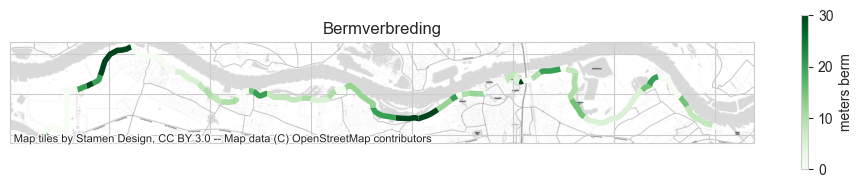

In [181]:
#bermverbreding
fig,ax = plt.subplots(figsize=(12,5))
GreedyResult.replace(-999,0).plot(ax=ax,column='dberm',linewidth=4,cmap='Greens', legend=True, legend_kwds={'label':'meters berm',"shrink":.4})

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_title('Bermverbreding')
# GreedyResult.loc[GreedyResult.VZG==1].plot(column='VZG',ax=ax,color='r',linestyle='-',linewidth=1,label='VZG')
ctx.add_basemap(ax,source=ctx.providers.Stamen.TonerLite)
plt.savefig(results_dir.joinpath(run,'extra_resultaten','bermverbreding.png'),dpi=300,bbox_inches='tight')

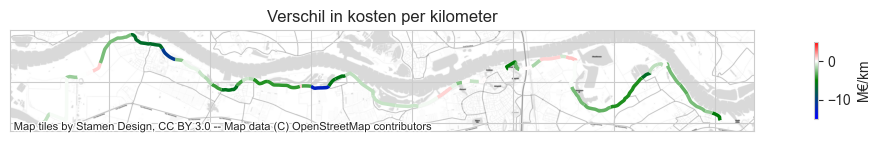

In [203]:
def map_of_measure_cost(data,data_type='Optimaal'):
    sns.set_style('whitegrid')
    fig,ax = plt.subplots(figsize=(12,5))
    data['cost per km'] = np.divide(data['LCC']/1e6,(data['VAKLENGTE']/1e3))
    data.plot(column='cost per km',ax=ax,cmap='RdYlGn_r',legend=True,vmin=0.1,vmax=20, linewidth=2.5,legend_kwds={'label':'M€/km',"shrink":.4})
    ctx.add_basemap(ax,source=ctx.providers.Stamen.TonerLite)
    ax.set_title('Kosten per kilometer - {}'.format(data_type))
    plt.savefig(results_dir.joinpath(run,'extra_resultaten','kosten_{}.png'.format(data_type)),dpi=300,bbox_inches='tight')

def map_of_measure_cost_diff(data,dif_col, data_type='Optimaal'):
    #dif_col is the column with the difference in LCC
    sns.set_style('whitegrid')
    fig,ax = plt.subplots(figsize=(12,5))
    data['cost per km (difference)'] = np.divide(data[dif_col]/1e6,(data['VAKLENGTE']/1e3))
    
    colors = [(0.0, 'blue'),(0.5, 'green'), (0.75, 'white'), (1.0, 'red')]
    cmap = LinearSegmentedColormap.from_list('custom_colormap',colors)
    data.plot(column='cost per km (difference)',ax=ax,legend=True, vmin=-15, vmax=5, cmap=cmap, linewidth=2.5,
                                   legend_kwds={'label':'M€/km',"shrink":.2,'anchor':(0.1,0.5)})
    # data.loc[data[dif_col]>0].plot(column='cost per km (difference)',ax=ax,cmap='OrRd',legend=True,vmin=0,vmax=np.ceil(np.max(data['cost per km (difference)'])), linewidth=2.5,
    #                                legend_kwds={'label':'M€/km',"shrink":.2,'anchor':(0.1,0.5)})
    # data.loc[data[dif_col]<0].plot(column='cost per km (difference)',ax=ax,cmap='YlGn_r',legend=True,vmin=np.floor(np.min(data['cost per km (difference)'])),vmax=0, linewidth=2.5,
    #                                legend_kwds={'label':'M€/km',"shrink":.2,'anchor':(-.0,0.5)})

    ctx.add_basemap(ax,source=ctx.providers.Stamen.TonerLite)
    ax.set_title('Verschil in kosten per kilometer')
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    plt.savefig(results_dir.joinpath(run,'extra_resultaten','kosten_verschil.png'),dpi=300,bbox_inches='tight')    

# map_of_measure_cost(GreedyResult)
# map_of_measure_cost(DsnResult,data_type = 'Doorsnede-eisen')
GreedyResult['verschil'] = GreedyResult.LCC - DsnResult.LCC
map_of_measure_cost_diff(GreedyResult,'verschil')

## Urgentie van vakken

In [41]:
def get_N_urgent_sections(TakenMeasures,n=20):
    sections = []
    for count, row in TakenMeasures.iterrows():
        if row.Section in sections:
            pass
        else:
            sections.append(row.Section)
        if len(sections) == n:
            break
    for i in range(0,len(sections)):
        sections[i] = sections[i].strip('DV')
    
    return pd.DataFrame([True]*len(sections),index=sections,columns=['scope ' + str(n) + ' vakken'])

def get_L_urgent_meters(TakenMeasures,vaklengtes, l=20000):
    total_length = 0
    sections = []
    for count, row in TakenMeasures.iterrows():
        if row.Section.strip('DV') in sections:
            # print('{} already in scope'.format(row.Section))
            pass
        else:
            sections.append(row.Section)
            total_length += vaklengtes.loc[row.Section.strip('DV')].VAKLENGTE
            sections[-1] = sections[-1].strip('DV')
            if total_length>l:
                # return sections, total_length
                return pd.DataFrame([True]*len(sections),index=sections,columns=['scope ' + str(np.int32(l/1000)) + ' km']), total_length      
    


TakenMeasures = pd.read_csv(results_dir.joinpath(run,'TakenMeasures_Veiligheidsrendement.csv'),index_col=0)
scopes = {}
scopes['scope 10 vakken'] = get_N_urgent_sections(TakenMeasures.loc[1:],n=10)
scopes['scope 20 vakken'] = get_N_urgent_sections(TakenMeasures.loc[1:],n=20)
scopes['scope 30 vakken'] = get_N_urgent_sections(TakenMeasures.loc[1:],n=30)

vaklengtes = shapefile[['NUMMER','VAKLENGTE']].set_index('NUMMER')
scopes['scope 5 km'] , l1 = get_L_urgent_meters(TakenMeasures.loc[1:],  vaklengtes, l=5000)
scopes['scope 10 km'], l2 = get_L_urgent_meters(TakenMeasures.loc[1:], vaklengtes, l=10000)
scopes['scope 15 km'], l3 = get_L_urgent_meters(TakenMeasures.loc[1:], vaklengtes,l=15000)
scopes['scope 20 km'], l3 = get_L_urgent_meters(TakenMeasures.loc[1:], vaklengtes,l=20000)

subset_greedy = copy.deepcopy(GreedyResult)[['OBJECTID', 'NUMMER','geometry','VAKLENGTE']]
for key in scopes.keys():
    subset_greedy = subset_greedy.merge(scopes[key], left_on='NUMMER',right_index=True,how='left')
subset_greedy = subset_greedy.fillna(value=False)

# subset_greedy = copy.deepcopy(GreedyResult)[['OBJECTID', 'NUMMER','geometry']]
# subset_greedy.merge(scopes[key], left_on='NUMMER',right_index=True,how='left')
# for count, row in subset_greedy.iterrows():
#     subset_greedy.loc[count] = row.

In [17]:
#grootste veiligheidstekort:
veiligheidstekort = shapefile.merge(InitialAssessmentBetas.loc[InitialAssessmentBetas.mechanism == 'Section'],left_on='NUMMER',right_on='name')
veiligheidstekort = veiligheidstekort.sort_values('0').reset_index(drop=True)
veiligheidstekort['cumulatieve lengte'] =veiligheidstekort.Length.cumsum()

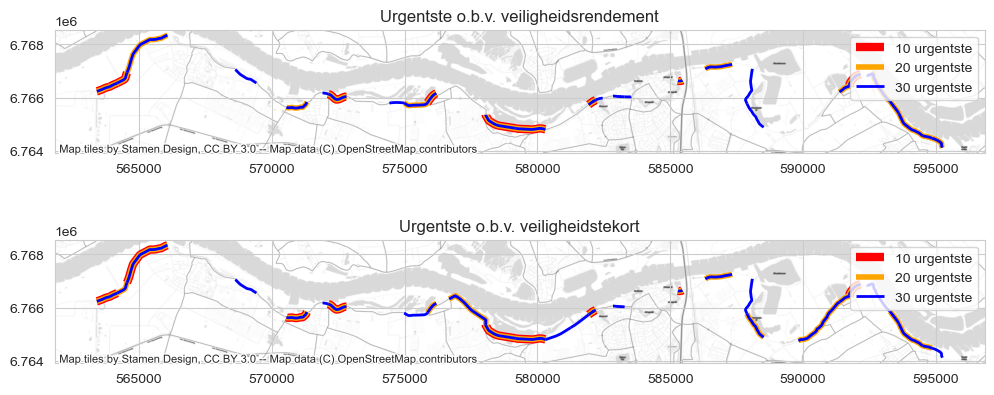

In [18]:
#partieel 20 vakken:
fig,ax = plt.subplots(figsize=(12,5),nrows=2)
subset_greedy.loc[subset_greedy['scope 10 vakken']].plot(ax=ax[0],categorical=True,legend=True,color='red',linewidth=6,label='10 urgentste')
subset_greedy.loc[subset_greedy['scope 20 vakken']].plot(ax=ax[0],categorical=True,legend=True,color='orange',linewidth=4,label='20 urgentste')
subset_greedy.loc[subset_greedy['scope 30 vakken']].plot(ax=ax[0],categorical=True,legend=True,color='blue',linewidth=2,label='30 urgentste')

ctx.add_basemap(ax[0],source=ctx.providers.Stamen.TonerLite)
ax[0].legend()
ax[0].set_title('Urgentste o.b.v. veiligheidsrendement')


veiligheidstekort.loc[0:9].plot(ax=ax[1],categorical=True,legend=True,color='red',linewidth=6,label='10 urgentste')
veiligheidstekort.loc[0:19].plot(ax=ax[1],categorical=True,legend=True,color='orange',linewidth=4,label='20 urgentste')
veiligheidstekort.loc[0:29].plot(ax=ax[1],categorical=True,legend=True,color='blue',linewidth=2,label='30 urgentste')
ctx.add_basemap(ax[1],source=ctx.providers.Stamen.TonerLite)

ax[1].legend()
ax[1].set_title('Urgentste o.b.v. veiligheidstekort')
plt.savefig(results_dir.joinpath(run,'extra_resultaten','urgentste_vakken.png'),dpi=300,bbox_inches='tight')



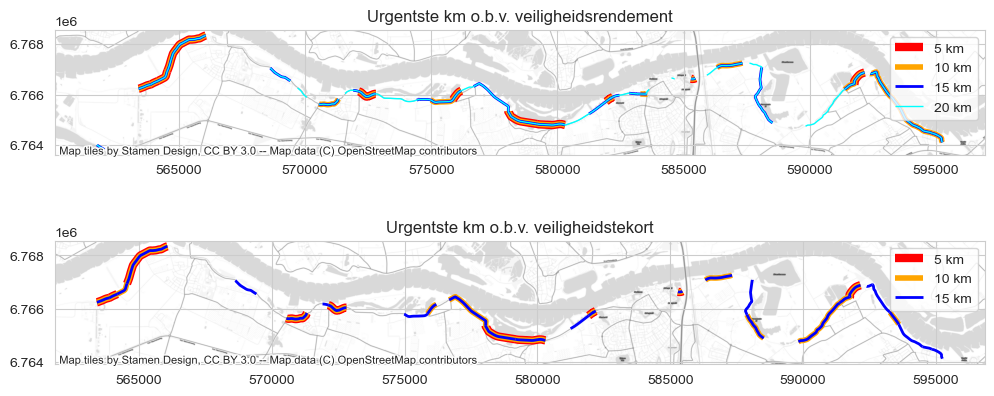

In [42]:
#scope 5, 10, 15 km:
fig,ax = plt.subplots(figsize=(12,5),nrows=2)
subset_greedy.loc[subset_greedy['scope 5 km']].plot(ax=ax[0],categorical=True,legend=True,color='red',linewidth=6,label='5 km')
subset_greedy.loc[subset_greedy['scope 10 km']].plot(ax=ax[0],categorical=True,legend=True,color='orange',linewidth=4,label='10 km')
subset_greedy.loc[subset_greedy['scope 15 km']].plot(ax=ax[0],categorical=True,legend=True,color='blue',linewidth=2,label='15 km')
subset_greedy.loc[subset_greedy['scope 20 km']].plot(ax=ax[0],categorical=True,legend=True,color='cyan',linewidth=1,label='20 km')

ctx.add_basemap(ax[0],source=ctx.providers.Stamen.TonerLite)
ax[0].legend()
ax[0].set_title('Urgentste km o.b.v. veiligheidsrendement')


veiligheidstekort.loc[0:veiligheidstekort.loc[veiligheidstekort['cumulatieve lengte']>5000].index[0]].plot(ax=ax[1],categorical=True,legend=True,color='red',linewidth=6,label='5 km')
veiligheidstekort.loc[0:veiligheidstekort.loc[veiligheidstekort['cumulatieve lengte']>10000].index[0]].plot(ax=ax[1],categorical=True,legend=True,color='orange',linewidth=4,label='10 km')
veiligheidstekort.loc[0:veiligheidstekort.loc[veiligheidstekort['cumulatieve lengte']>15000].index[0]].plot(ax=ax[1],categorical=True,legend=True,color='blue',linewidth=2,label='15 km')
ctx.add_basemap(ax[1],source=ctx.providers.Stamen.TonerLite)

ax[1].legend()
ax[1].set_title('Urgentste km o.b.v. veiligheidstekort')
plt.savefig(results_dir.joinpath(run,'extra_resultaten','urgentste_vakken_kms.png'),dpi=300,bbox_inches='tight')



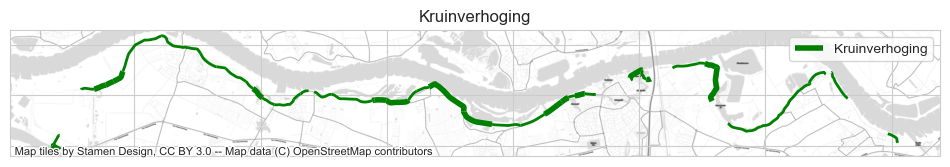

In [20]:
#maatregelen op kaart

#kruinverhoging:
sns.set_style('whitegrid')
fig,ax = plt.subplots(figsize=(12,5))
for crestheight in np.unique(GreedyResult.dcrest):
    if (crestheight >0) and (crestheight != np.max(np.unique(GreedyResult.dcrest))):
        
        GreedyResult.loc[GreedyResult.dcrest==crestheight].plot(ax=ax,color='green',linewidth=crestheight*4)
    elif crestheight >0:
        
        GreedyResult.loc[GreedyResult.dcrest==crestheight].plot(ax=ax,color='green',linewidth=crestheight*4,label='Kruinverhoging')
                           
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_title('Kruinverhoging')
# GreedyResult.loc[GreedyResult.VZG==1].plot(column='VZG',ax=ax,color='r',linestyle='-',linewidth=1,label='VZG')
ctx.add_basemap(ax,source=ctx.providers.Stamen.TonerLite)
ax.legend()
plt.savefig(results_dir.joinpath(run,'extra_resultaten','kruinverhoging.png'),dpi=300,bbox_inches='tight')

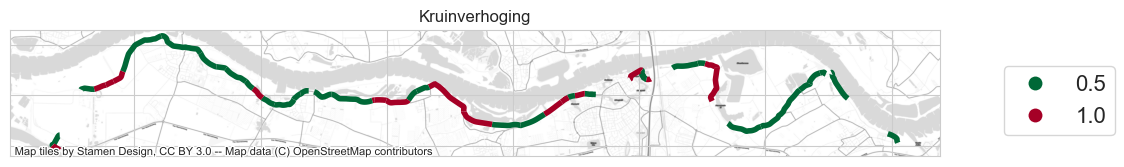

In [ ]:
TakenMeasures